In [2]:
import reservoirpy as rpy
from reservoirpy.datasets import (lorenz, mackey_glass, narma)
from reservoirpy.observables import (rmse, rsquare, nrmse, mse)
import numpy as np
import math
import pandas as pd
from functools import partial
import sys
import os
import time
import matplotlib.pyplot as plt

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath('../'))
import NAS.NAS
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings("ignore")

rpy.verbosity(0)
output_dim = 1

In [3]:
def nrmseGESN(yTrue, preds):
    norm = 0
    mse = 0
    targetMean = np.mean(yTrue)
    for i, target in enumerate(yTrue):
        norm+=(target - targetMean)**2
        mse+=(target - preds[i])**2
    return math.sqrt(mse/norm)

def nmse(y, o):
    assert len(o) == len(y), "Both arrays must have the same length."
    sigma2 = np.var(y)  # variance of y
    i = len(y)
    error = sum((o[t] - y[t])**2 for t in range(i))
    return error / (i * sigma2)

def mae(y, o):
    assert len(o) == len(y), "Both arrays must have the same length."
    i = len(y)
    error = sum(abs(o[t] - y[t]) for t in range(i))
    return error / i

def mape(y, o):
    assert len(o) == len(y), "Both arrays must have the same length."
    i = len(y)
    error = sum(abs(o[t] - y[t]) / abs(y[t]) for t in range(i))
    return (error / i) * 100

def nrmseDBESN(yTrue, preds):
    norm = 0
    mse = 0
    targetMean = np.mean(yTrue)
    for i, target in enumerate(yTrue):
        norm+=(target - targetMean)**2
        mse+=(target - preds[i])**2
    return math.sqrt(mse/norm)

def nrmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mean_norm = np.linalg.norm(np.mean(y_true))
    
    return rmse / mean_norm

def r_squared(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - np.mean(y_true))**2)
    
    return 1 - (numerator / denominator)


def evaluate_one_model(model, trainX, trainY, valX, valY):
    try:
        performance = NAS.evaluateModel(model, trainX, trainY, valX, valY)
        if math.isnan(performance):
            return np.inf, model
        else:
            return performance, model
    except NAS.TimeoutException as e:
        return np.inf, model
    except:
        return np.inf, model

def evaluate(individual, trainX, trainY, valX, valY, numEvals = 5):
    performances = []
    models = []
    untrainedModels = [NAS.constructModel(individual) for _ in range(numEvals)]

    try:
        results = Parallel(n_jobs=5, timeout=60)(delayed(evaluate_one_model)(model, trainX, trainY, valX, valY) for model in untrainedModels)
    except:
        return np.inf, untrainedModels[0]
    
    for performance, model in results:
        performances.append(performance)
        models.append(model)

    # If there are no successful results, you can return default or placeholder values
    if not performances:
        return np.inf, None
    
    return min(performances), models[performances.index(min(performances))]


In [3]:
# https://www.sciencedirect.com/science/article/pii/S0925231222014291
# Parameterizing echo state networks for multi-step time series prediction
# Mackey glass dataset

def getData():
    data = np.load('../data/MG17.npy')
    data = data.reshape((data.shape[0],1))
    data = data[:3801,:]
    from scipy import stats
    data = stats.zscore(data)
    data.shape

    trainLen = 1100
    valLen = 286
    testLen = 286
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(NAS.NAS.evaluateArchitecture, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.NAS.generateRandomArchitecture, sampleX=trainX[:2], sampleY=trainY[:2]),
    "populationSize": 15,
    "eliteSize": 1,
    "stagnationReset": 5,
    "generations": 20,
    "minimizeFitness": True,
    "logModels": False,
    "seedModels": [
        # {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'Reservoir', 'params': {'units': 2048, 'input_connectivity': 0.44, 'rc_connectivity': 0.44, 'fb_connectivity': 0.44, 'sr': 1.406, 'lr': 0.68}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 6.0e-7}}, ], 'edges': [[0, 1], [1, 2]]}
    ],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0,
    "n_jobs": 5
}

nrmseErrors = []
r2Errors = []
for i in range(1):
    models, performances, architectures = NAS.NAS.runGA(gaParams)
    allPreds = []
    for architecture in architectures[:5]:
        for _ in range(10):
            model = NAS.NAS.constructModel(architecture)
            model = NAS.NAS.trainModel(model, np.concatenate([trainX, valX[:-20]]), np.concatenate([trainY, valY[:-20]]))
            prevOutput = valX[-20]
            preds = []
            for j in range(20+len(testX)):
                pred = NAS.NAS.runModel(model, prevOutput)
                prevOutput = pred
                preds.append(pred[0])
            preds = np.array(preds)
            allPreds.append(preds)
    valErrors = []
    for pred in allPreds:
        valError = nrmse(valY[-20:], pred[:20])
        error = nrmse(testY, pred[-len(testY):])
        valErrors.append(valError)
    bestPred = allPreds[valErrors.index(min(valErrors))]
    print(performances[0:5], min(valErrors), nrmse(testY, bestPred[-len(testY):]), r_squared(testY, bestPred[-len(testY):]))
    if min(valErrors)>0.0003:
        continue
    nrmseErrors.append(nrmse(testY, bestPred[-len(testY):]))
    r2Errors.append(r_squared(testY, bestPred[-len(testY):]))

print(np.array(nrmseErrors).mean(), np.array(nrmseErrors).std())
print(np.array(r2Errors).mean(), np.array(r2Errors).std())

[0.228129311960515, 0.3660608203150648, 0.5342405279865889, 0.5821800327187896, 0.8017676653301289] 0.00013600086395423744 0.13077302810030897
0.13077302810030897 0.0
0.9999060198302299 0.0


In [58]:
def getData():
    data = np.load('../data/MG17.npy')
    data = data.reshape((data.shape[0],1))
    data = data[:3801,:]
    from scipy import stats
    data = stats.zscore(data)
    data.shape

    trainLen = 2000
    valLen = 286
    testLen = 286
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

Performance 0.0015039412089937715 0.9999793732433853
Performance 0.6436950541068868 0.9999793732433853


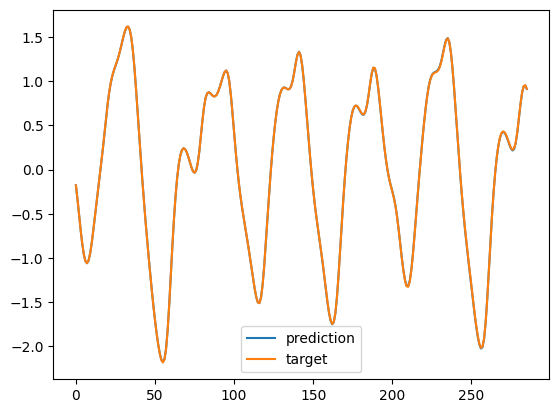

In [65]:
model = NAS.NAS.constructModel({'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 1}}, {'type': 'Reservoir', 'params': {'units': 649, 'lr': 0.5975855910585006, 'sr': 1.289221609815766, 'input_connectivity': 0.40010488298206637, 'rc_connectivity': 0.4090786446967834, 'fb_connectivity': 0.09404210228238652}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 2}}, {'type': 'IPReservoir', 'params': {'units': 234, 'lr': 0.9203822465220324, 'sr': 0.5177516030001565, 'mu': 0.0661244738966123, 'sigma': 1.4035618806583001, 'learning_rate': 0.00327840184422856, 'input_connectivity': 0.14644358488436113, 'rc_connectivity': 0.3713680820702342, 'fb_connectivity': 0.273826121341471}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 2}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 6.045376465443952e-05}}], 'edges': [[0, 1], [0, 2], [0, 3], [1, 4], [3, 5], [2, 6], [4, 6], [5, 6]]})
model = NAS.NAS.trainModel(model, np.concatenate([trainX, valX[:-20]]), np.concatenate([trainY, valY[:-20]]))
# NAS.NAS.runModel(model, valX)
prevOutput = valX[-20]
preds = []
for j in range(20+len(testX)):
    pred = NAS.NAS.runModel(model, prevOutput)
    prevOutput = pred
    preds.append(pred[0])
preds = np.array(preds)
print("Performance", nrmse(valY[-20:], preds[:20]), r_squared(testY, preds[-len(testY):]))
print("Performance", nrmse(testY, preds[-len(testY):]), r_squared(testY, preds[-len(testY):]))

plt.plot(preds[20:], label='prediction')  # Plot the second array
plt.plot(testY, label='target')  # Plot the second array
plt.legend()  # Display the labels in the legend

plt.show()

In [64]:
nrmse(testY, preds[-len(testY):])

2.9716816755671855

In [3]:
# https://www.sciencedirect.com/science/article/pii/S0925231222014291
# Parameterizing echo state networks for multi-step time series prediction
# Santafe laser dataset

def getData():
    sunspots = pd.read_csv("../data/santafelaser.csv")
    data = np.array(sunspots)

    trainLen = 9891
    valLen = 100
    testLen = 100
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(NAS.NAS.evaluateArchitecture, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.NAS.generateRandomArchitecture, sampleX=trainX[:2], sampleY=trainY[:2]),
    "populationSize": 15,
    "eliteSize": 1,
    "stagnationReset": 5,
    "generations": 10,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [
        # {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'Reservoir', 'params': {'units': 2048, 'input_connectivity': 0.44, 'rc_connectivity': 0.44, 'fb_connectivity': 0.44, 'sr': 1.406, 'lr': 0.68}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 6.0e-7}}, ], 'edges': [[0, 1], [1, 2]]}
    ],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0,
    "n_jobs": 5
}

nrmseErrors = []
r2Errors = []
for i in range(1):
    models, performances, architectures = NAS.NAS.runGA(gaParams)
    allPreds = []
    for architecture in architectures[:5]:
        for _ in range(10):
            model = NAS.NAS.constructModel(architecture)
            model = NAS.NAS.trainModel(model, np.concatenate([trainX, valX[:-20]]), np.concatenate([trainY, valY[:-20]]))
            prevOutput = valX[-20]
            preds = []
            for j in range(20+len(testX)):
                pred = NAS.NAS.runModel(model, prevOutput)
                prevOutput = pred
                preds.append(pred[0])
            preds = np.array(preds)
            allPreds.append(preds)
    valErrors = []
    for pred in allPreds:
        valError = nrmse(valY[-20:], pred[:20])
        error = nrmse(testY, pred[-len(testY):])
        valErrors.append(valError)
    bestPred = allPreds[valErrors.index(min(valErrors))]
    print(performances[0:5], min(valErrors), nrmse(testY, bestPred[-len(testY):]))
    # if min(valErrors)>0.0003:
    #     continue
    nrmseErrors.append(nrmse(testY, bestPred[-len(testY):]))
    r2Errors.append(r_squared(testY, bestPred[-len(testY):]))

print(np.array(nrmseErrors).mean(), np.array(nrmseErrors).std())
print(np.array(r2Errors).mean(), np.array(r2Errors).std())

inf {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 1, 'order': 1, 'strides': 1}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 7.566465540941455e-05}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.44102428592926246}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 6.025376598082588e-06}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 9.9584953584808e-05}}], 'edges': [[0, 1], [1, 2], [1, 3], [1, 4], [2, 5], [3, 5], [4, 5]]}
0.9330394903442772 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 2.2694320815997462e-05}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 2.8215816822639563e-05}}, {'type': 'IPReservoir', 'params': {'units': 1251, 'lr': 0.4596392742184165, 'sr': 0.6840221351887465, 'mu': -0.13360157786954296, 'sigma': 1.0226518500237052, 'learning_rate': 0.00297281604213538, 'input_connectivity': 0.16589004713579905, 'rc_connectivity': 0.2850336866745172

In [1]:

def getData():
    sunspots = pd.read_csv("../data/santafelaser.csv")
    data = np.array(sunspots)

    trainLen = 9891
    valLen = 100
    testLen = 100
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

NameError: name 'pd' is not defined

In [4]:
goodArchitecture = {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 1}}, {'type': 'Reservoir', 'params': {'units': 649, 'lr': 0.5975855910585006, 'sr': 1.289221609815766, 'input_connectivity': 0.40010488298206637, 'rc_connectivity': 0.4090786446967834, 'fb_connectivity': 0.09404210228238652}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 2}}, {'type': 'IPReservoir', 'params': {'units': 234, 'lr': 0.9203822465220324, 'sr': 0.5177516030001565, 'mu': 0.0661244738966123, 'sigma': 1.4035618806583001, 'learning_rate': 0.00327840184422856, 'input_connectivity': 0.14644358488436113, 'rc_connectivity': 0.3713680820702342, 'fb_connectivity': 0.273826121341471}}, {'type': 'NVAR', 'params': {'delay': 4, 'order': 2, 'strides': 2}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 6.045376465443952e-05}}], 'edges': [[0, 1], [0, 2], [0, 3], [1, 4], [3, 5], [2, 6], [4, 6], [5, 6]]}

model = NAS.NAS.constructModel(goodArchitecture)
model = NAS.NAS.trainModel(model, np.concatenate([trainX, valX[:-20]]), np.concatenate([trainY, valY[:-20]]))
prevOutput = valX[-20]
preds = []
for j in range(20+len(testX)):
    pred = NAS.NAS.runModel(model, prevOutput)
    prevOutput = pred
    preds.append(pred[0])

print(nrmse(testY, preds[-len(testY):]), r_squared(testY, preds[-len(testY):]))

0.03571277158613166 0.9897931229697442


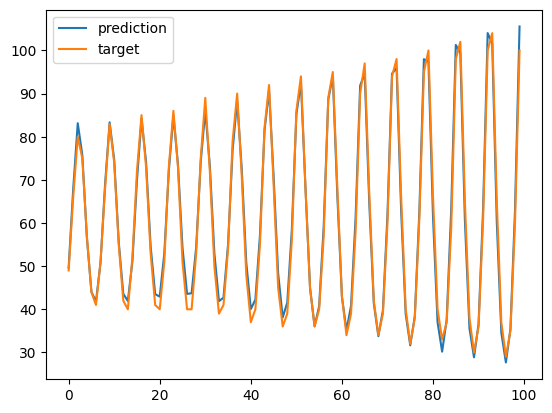

In [6]:
plt.plot(preds[-len(testY):], label='prediction')  # Plot the second array
plt.plot(testY, label='target')  # Plot the second array
plt.legend()  # Display the labels in the legend

plt.show()

In [9]:
# https://www.sciencedirect.com/science/article/pii/S0925231222014291
# Parameterizing echo state networks for multi-step time series prediction
# Neutral normed dataset

def getData():
    data = np.load('../data/Neutral_normed_2801.npy')

    trainLen = 1901
    valLen = 399
    testLen = 500
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 2,
    "stagnationReset": 5,
    "generations": 22,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0
}

nrmseErrors = []
r2Errors = []
for i in range(1):
    models, performances, architectures = NAS.runGA(gaParams)
    model = models[0]
    startInput = testX[0]
    prevOutput = testX[0]
    preds = []
    for j in range(len(testX)):
        pred = NAS.runModel(model, prevOutput)
        prevOutput = pred
        preds.append(pred[0])
    preds = np.array(preds)
    performance = r_squared(testY, preds)
    print("Performance", performance, nrmse(testY, preds))
    nrmseErrors.append(nrmse(testY, preds))
    r2Errors.append(performance)

print(np.array(nrmseErrors).mean(), np.array(nrmseErrors).std())
print(np.array(r2Errors).mean(), np.array(r2Errors).std())

Performance 0.999958227868178 7.311027348144948
Performance 0.9995362054529383 22.118367018388145
Performance -1.2067514774276298 2696.8280088904735
Performance -7.385636140212117 2739.3385181107597
Performance 0.9999629568174395 6.1284839531925925
Performance 0.9804485629026151 137.29728648428116
Performance 0.9999843941124462 4.420965116672592
Performance 0.9999883553787924 4.301596708526212
Performance 0.9999590021977057 6.849569508367799
Performance 0.9853479619681731 119.301864090258
574.3895687229065


In [6]:
# https://www.sciencedirect.com/science/article/pii/S0925231222014291
# Parameterizing echo state networks for multi-step time series prediction
# Lorenz dataset

def getData():
    data = np.load('../data/Lorenz_normed_2801.npy')

    trainLen = 1957
    valLen = 399
    testLen = 444
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 2,
    "stagnationReset": 5,
    "generations": 22,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0
}

nrmseErrors = []
r2Errors = []
for i in range(1):
    models, performances, architectures = NAS.runGA(gaParams)
    model = models[0]
    startInput = testX[0]
    prevOutput = testX[0]
    preds = []
    for j in range(len(testX)):
        pred = NAS.runModel(model, prevOutput)
        prevOutput = pred
        preds.append(pred[0])
    preds = np.array(preds)
    performance = r_squared(testY, preds)
    print("Performance", performance, nrmse(testY, preds))
    nrmseErrors.append(nrmse(testY, preds))
    r2Errors.append(performance)

print(np.array(nrmseErrors).mean(), np.array(nrmseErrors).std())
print(np.array(r2Errors).mean(), np.array(r2Errors).std())


ValueError: Ridge-10is  expecting data of shape (6,) but received shape (3,).

In [ ]:
def getLorenzData():
    data = np.array(lorenz(n_timesteps=10000, rho=28, sigma=10, beta=8/3, x0=[1, 1, 0]))
    train = data[:4000]
    val = data[4000:8000]
    test = data[8000:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY

def getMackeyData():
    data = np.array(mackey_glass(n_timesteps=10000, ))
    train = data[:4000]
    val = data[4000:8000]
    test = data[8000:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY

In [3]:
def getData():
    sunspots = pd.read_csv("../datasets/Sunspots.csv")
    data = sunspots.loc[:,"Monthly Mean Total Sunspot Number"]
    data1 = np.expand_dims(data[:-20], axis=1)
    data2 = np.expand_dims(data[10:-10], axis=1)
    data3 = np.expand_dims(data[20:], axis=1)
    y = data3[1:]
    x = np.concatenate([data1, data2, data3], axis=-1)[:-1]

    trainX = x[:1600]
    trainY = y[:1600]
    valX = x[1600:2100]
    valY = y[1600:2100]
    testX = x[2100:3174]
    testY = y[2100:3174]
    return trainX, trainY, valX, valY, testX, testY

trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 3,
    "stagnationReset": 5,
    "generations": 5,
    "minimizeFitness": True,
    "logModels": False,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0
}

errors = []
for i in range(20):
    models, performances, architectures = NAS.runGA(gaParams)
    model = models[0]
    preds = NAS.runModel(model, testX)
    performance = nrmseGESN(testY, preds)
    print("Performance", performance)
    errors.append(performance)

print(np.array(errors).mean(), np.array(errors).std())

In [3]:
def getData():
    data = np.array(narma(n_timesteps=10000, order=10, a1=0.3, a2=0.05, b=1.5, c=0.1))
    train = data[:4000]
    val = data[4000:8000]
    test = data[8000:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY
trainX, trainY, valX, valY, testX, testY = getData()

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 3,
    "stagnationReset": 5,
    "generations": 5,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0
}

nmseErrors = []
maeErrors = []
mapeErrors = []
for i in range(1):
    models, performances, architectures = NAS.runGA(gaParams)
    model = models[0]
    preds = NAS.runModel(model, testX)
    
    performance = nmse(testY, preds)
    print("Performance", nmse(testY, preds), mae(testY, preds), mape(testY, preds))
    nmseErrors.append(nmse(testY, preds))
    maeErrors.append(mae(testY, preds))
    mapeErrors.append(mape(testY, preds))

print(np.array(nmseErrors).mean(), np.array(nmseErrors).std())
print(np.array(maeErrors).mean(), np.array(maeErrors).std())
print(np.array(mapeErrors).mean(), np.array(mapeErrors).std())

0.806328925423417 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 1, 'order': 2, 'strides': 1}}, {'type': 'IPReservoir', 'params': {'units': 204, 'lr': 0.4274687670213947, 'sr': 0.6043192857823759, 'mu': 0.14098592510132557, 'sigma': 1.4811575680149511, 'learning_rate': 0.005711708256562583}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 1.8581639777161584e-05}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 2.0356202523372214e-05}}], 'edges': [[0, 1], [1, 3], [1, 2], [0, 3], [2, 4], [3, 4]]}
0.8127237797980299 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.4720927959834079}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.8717784171693826}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.6522373309780006}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.7327109783609205}}], 'edges': [[0, 1], [1, 3], [0, 2], [2, 3], [3, 4]]}
0.7512717717307119 {'nodes': [{'typ

In [6]:

def nrmse2(yTrue, preds):
    norm = len(yTrue) * np.var(yTrue)
    mse = 0
    targetMean = np.mean(yTrue)
    for i, target in enumerate(yTrue):
        mse+=(preds[i] - target)**2
    return math.sqrt(mse/norm)

nrmse2(testY, preds)

0.7825875984435665

In [2]:
def getData():
    data = np.array(narma(n_timesteps=10000, order=10, a1=0.3, a2=0.05, b=1.5, c=0.1))
    train = data[:4000]
    val = data[4000:8000]
    test = data[8000:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY
trainX, trainY, valX, valY, testX, testY = getData()

def evaluate(individual, trainX, trainY, valX, valY, numEvals = 5, returnModel=False):
    performances = []
    models = []
    for i in range(numEvals):
        model = NAS.constructModel(individual)
        models.append(model)
        try:
            performance = NAS.evaluateModel(model, trainX, trainY, valX, valY)
            if math.isnan(performance):
                performances.append(np.inf)
            else:
                performances.append(performance)
        except NAS.TimeoutException as e:
            return np.inf
        except:
            performances.append(np.inf)
    if returnModel:
        model = models[performances.index(min(performances))]
        model = NAS.trainModel(model, np.concatenate((trainX, valX), axis=0), np.concatenate((trainY, valY), axis=0))
        return model
    else:
        return min(performances)

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 3,
    "randomPopulationSize": 6,
    "generations": 5,
    "minimizeFitness": True,
    "logModels": False,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
}

errors = [0.15405173054445626, 0.1520069746854343, 0.15229088319906717, 0.15040759886341698, 0.15114486316648684]
# for i in range(20):
#     best_architecture, model = NAS.runGA(gaParams)
#     preds = NAS.runModel(model, testX)
#     performance = nrmse(testY, preds)
#     print("Performance", performance)
#     print(best_architecture)
#     errors.append(performance)

print(np.array(errors).mean(), np.array(errors).std())

0.15198041009177232 0.0012295805358000082


In [7]:
def getData():
    data = np.array(narma(n_timesteps=8000, order=10, a1=0.3, a2=0.05, c=0.1))
    train = data[:2800]
    val = data[2800:5600]
    test = data[5600:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY
trainX, trainY, valX, valY, testX, testY = getData()

def nrmseGESN(yTrue, preds):
    norm = 0
    targetMean = np.mean(yTrue)
    for target in yTrue:
        norm+=(target - targetMean)**2
    norm = math.sqrt(norm)
    return nrmse(yTrue, preds, norm_value=norm)

def evaluateModel(model, trainX, trainY, valX, valY):
    model = NAS.trainModel(model, trainX, trainY)
    preds = NAS.runModel(model, valX)
    return nrmseGESN(valY, preds)

def evaluate(individual, trainX, trainY, valX, valY, numEvals = 5):
    performances = []
    models = []
    for i in range(numEvals):
        model = NAS.constructModel(individual)
        models.append(model)
        try:
            performance = evaluateModel(model, trainX, trainY, valX, valY)
            if math.isnan(performance):
                performances.append(np.inf)
            else:
                performances.append(performance)
        except NAS.TimeoutException as e:
            return (np.inf, models[0])
        except:
            performances.append(np.inf)
    return min(performances), models[performances.index(min(performances))]

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 3,
    "stagnationReset": 5,
    "generations": 5,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
    "earlyStop": 0
}

errors = []
for i in range(1):
    models, performances, architectures = NAS.runGA(gaParams)
    model = models[0]
    preds = NAS.runModel(model, testX)
    performance = nrmseGESN(testY, preds)
    print("Performance", performance)
    errors.append(performance)

print(np.array(errors).mean(), np.array(errors).std())

0.0197868616080943 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 3, 'order': 1, 'strides': 1}}, {'type': 'Reservoir', 'params': {'units': 476, 'lr': 0.9271130609120093, 'sr': 1.0450872973184036}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.3970924367228661}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.5093040901396275}}], 'edges': [[0, 1], [1, 2], [0, 2], [2, 3], [1, 3], [3, 4]]}
0.018737155666490406 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 1, 'order': 2, 'strides': 2}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.5318929322231087}}, {'type': 'Reservoir', 'params': {'units': 346, 'lr': 0.6814247986559525, 'sr': 1.5036954916630931}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.8635757498618607}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.9682927683590249}}], 'edges': [[0, 1], [1, 2], [0, 2], [2, 4], [2, 3], [3, 5], [4, 5]]}
0.015024964882125565 {'nodes': 

In [7]:
def getData():
    data = np.array(mackey_glass(n_timesteps=5000))
    train = data[:2000]
    val = data[2000:3000]
    test = data[3000:]
    trainX = train[:-1]
    trainY = train[1:]
    valX = val[:-1]
    valY = val[1:]
    testX = test[:-1]
    testY = test[1:]
    return trainX, trainY, valX, valY, testX, testY
trainX, trainY, valX, valY, testX, testY = getData()

def evaluate(individual, trainX, trainY, valX, valY, numEvals = 5, returnModel=False):
    performances = []
    models = []
    for i in range(numEvals):
        model = NAS.constructModel(individual)
        models.append(model)
        try:
            performance = NAS.evaluateModel(model, trainX, trainY, valX, valY)
            if math.isnan(performance):
                performances.append(np.inf)
            else:
                performances.append(performance)
        except NAS.TimeoutException as e:
            return np.inf
        except:
            performances.append(np.inf)
    if returnModel:
        model = models[performances.index(min(performances))]
        model = NAS.trainModel(model, np.concatenate((trainX, valX), axis=0), np.concatenate((trainY, valY), axis=0))
        return model
    else:
        return min(performances)

gaParams = {
    "evaluator": partial(evaluate, trainX=trainX, trainY=trainY, valX=valX, valY=valY),
    "generator": partial(NAS.generateRandomArchitecture, sampleX=trainX[:100], sampleY=trainY[:100]),
    "populationSize": 15,
    "eliteSize": 3,
    "randomPopulationSize": 6,
    "generations": 5,
    "minimizeFitness": True,
    "logModels": True,
    "seedModels": [],
    "crossoverProbability": 0.7,
    "mutationProbability": 0.2,
}

goodModel1 = {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'NVAR', 'params': {'delay': 2, 'order': 2, 'strides': 2}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 4.2400712789455064e-05}}, {'type': 'IPReservoir', 'params': {'units': 295, 'lr': 0.5359079211942819, 'sr': 0.6654730167698824, 'mu': 0.1463740181542243, 'sigma': 0.6103636106854304, 'learning_rate': 0.006400550479015955}}, {'type': 'Ridge', 'params': {'output_dim': 1, 'ridge': 9.622497237259488e-05}}], 'edges': [[0, 1], [1, 3], [0, 2], [0, 3], [2, 4], [3, 4]]}

errors = [0.00432905949197937, 0.0027860899571542407, 0.000639761940998179]
for i in range(20):
    best_architecture, model = NAS.runGA(gaParams)
    preds = NAS.runModel(model, testX)
    performance = nrmse(testY, preds)
    print("Performance", performance)
    print(best_architecture)
    errors.append(performance)

print(np.array(errors).mean(), np.array(errors).std())

0.005754466976040041 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'Reservoir', 'params': {'units': 465, 'lr': 0.9731019365550598, 'sr': 0.5981183515503958}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.31576941311732376}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.6573955370130024}}, {'type': 'Reservoir', 'params': {'units': 457, 'lr': 0.8259198796459414, 'sr': 1.1115955384897451}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.9832771093743055}}], 'edges': [[0, 1], [1, 3], [0, 2], [2, 4], [0, 4], [3, 5], [4, 5]]}
0.3373541732553341 {'nodes': [{'type': 'Input', 'params': {}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.9957845623894098}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.4395905069484437}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.7921980307892675}}, {'type': 'LMS', 'params': {'output_dim': 1, 'alpha': 0.5217982958209176}}, {'type': 'RLS', 'params': {'output_dim': 1, 'alpha': 0.7306689496591016}}, {

In [10]:
print(np.array(errors[2:]).mean(), np.array(errors[2:]).std())

0.0010571087602075737 0.0013953424416030512
